In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.impute
from tqdm import tqdm

In [59]:
DATA_PATH = 'data/bank-full.csv'

In [60]:
df = pd.read_table(DATA_PATH, sep=',')

df.shape

(45211, 17)

In [61]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# <ins> DUPLICATES

In [62]:
df.duplicated().sum()

0

# <ins> FEATURE ENGINEERING

In [63]:
### Following data exploration, the features are engineered as such:
# - age: as is.
# - balance: as is.
# - campaign: turn into categorical with bins 1, 2-8, 8+
# - contact: remove, because very similar distribution in target categories and considered irrelevant.   
# - day: remove, considered irrelevant.
# - default: as is.
# - duration: remove, because it has no predictive value (can't be known at prediction time).
# - education: as is.
# - housing: as is.
# - job: as is
# - loan: as is.
# - marital: as is.
# - month: remove, because the bank want to find the customers the would probably say "yes" and 
#       their attitude is based on personal characteristics, not the month they get called.
#       As discussed above, the month may influence the outcome of the call and it would be interesting
#       to understand how, but this is not the aim of the oresent analysis.
# - pdays: binarize, to "never contacted before for another campaign", "1-200 days", "201-400 days", "400+ days"
# - poutcome: turn "other" to "unknown", since an "other" equates to an "unknown" since 
#       for us it's important whether the target is "yes" or "no", not inbetween.
# - previous: as is.

In [64]:
# Number of contacts for this campaign (categorical)
df['n_contacts'] = pd.cut(df.campaign, bins=(0, 1, 8, float('inf')), labels=['1', '2-8', '8+'], include_lowest=True)

# Pdays as categorical
df['pdays'] = pd.cut(df.pdays, bins=(float('-inf'), 0, 200, 400, float('inf')), labels=('never_contacted_before', '1-200', '201-400', '400+'), include_lowest=True )

# Add feature similar to "previous" and "pdays":
# Has the client been contacted before this campaign for other campaign?
df['contacted_before'] = df.previous.apply(lambda x: 1 if x > 0 else 0)

In [65]:
df.drop(['duration', 'day', 'month', 'contact', 'campaign'], axis=1, inplace=True)

In [66]:
# To numeric binary
df['y'] = df.y.replace({'no': 0, 'yes': 1})
df['default'] = df.default.replace({'no': 0, 'yes': 1})
df['loan'] = df.loan.replace({'no': 0, 'yes': 1})
df['housing'] = df.housing.replace({'no': 0, 'yes': 1})

In [67]:
df['poutcome'] = df['poutcome'].replace({'other': 'unknown'})

In [68]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,y,n_contacts,contacted_before
0,58,management,married,tertiary,0,2143,1,0,never_contacted_before,0,unknown,0,1,0
1,44,technician,single,secondary,0,29,1,0,never_contacted_before,0,unknown,0,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,never_contacted_before,0,unknown,0,1,0


In [ ]:
### Possible feature engineering ideas, to add redundant binned features.
# df['balance_positive'] = np.where(df.balance > 0, 1, 0)
# df['duration_positive'] = np.where(df.duration > 0, 1, 0)
# df['contacted_before'] = np.where(df.previous > 0, 1, 0)

# df['age_bin'] = pd.cut(df.age, bins=[0, 29, 59, float('inf')], labels=['<30', '30-59', '>=60'], include_lowest=True)
# df['balance_bin'] = pd.cut(df.balance, bins=[float('-inf'), 99, float('inf')], labels=['<100', '>=100'], include_lowest=True)
# df['duration_bin'] = pd.cut(df.duration, bins=[float('-inf'), 249, float('inf')], labels=['<250', '>=250'], include_lowest=True)
# df['campaign_bin'] = pd.cut(df.campaign, bins=[float('-inf'), 3, float('inf')], labels=['<=3', '3'], include_lowest=True)

# <ins> MISSING VALUES

In [69]:
# Replace with NA for job and education,
# not form "poutcome" for they are too many and
# we'll keep the "unknown" class
df['job'].replace({'unknown': np.nan}, inplace=True)
df['education'].replace({'unknown': np.nan}, inplace=True)

In [70]:
df.isna().sum(axis=0)

age                    0
job                  288
marital                0
education           1857
default                0
balance                0
housing                0
loan                   0
pdays                  0
previous               0
poutcome               0
y                      0
n_contacts             0
contacted_before       0
dtype: int64

In [71]:
# Target distribution in the records with at least a NA
# it reflects the distribution in the overall population
na_df = df[df.isna().sum(axis=1) > 0]
target_na = na_df.y.value_counts().round(2)
target_na, target_na.div(target_na.sum()).round(2)

(y
 0    1750
 1     268
 Name: count, dtype: int64,
 y
 0    0.87
 1    0.13
 Name: count, dtype: float64)

In [72]:
# Proportion of target "yes" records with NAs
target_na[1] / df.y.value_counts()[1]

0.05067120438646247

In [73]:
# NA strategies: 
# 1. Removal (cons: we lose 5% of data)
# 2. Imputation via KNN

## KNN IMPUTATION

In [74]:
# - we could use sklearn's KNN imputer but instead we chose the hard way.

# - in any case, sklearn requires one-hot encoded feature.

# - Nomenclature:
#   - feature: one of the features from the original dataset (ex: "job").
#   - ohe feature: one of the features of the one-hot encoded version of the dataset (ex: "job_housemaid").

# - Performing one-hot encoding on a df with NAs via `pd.get_dummies()` turn a feature with the NA
#   into a series of ohe features each one with value = 0. so those zeros will be used to find the neighbors. 
#   But these zeros impose a particular meaning, i.e., they create artificial proximities/distances, and 
#   consequently, the neighbors found will not be very reliable. For this reason we have to turn to fake zeros
#   back to NAs.

In [75]:
# NAs are in the job and education features.
# We need to select a set of features meaningful with respect to job and education
# to use for the imputation.
selected_features = ['job', 'education', 'age', 'marital', 'balance', 'housing', 'loan']

In [76]:
categorical_features = [feat for feat in df.columns if df[feat].dtype in ['object', 'category']]
categorical_features

['job', 'marital', 'education', 'pdays', 'poutcome', 'n_contacts']

In [77]:
# Create one-hot encoded df, 
# adding specific ohe features to indicate whether each feature has NAs (dummy_na),
# which will come in handy for NA imputation.
ohe_df = pd.get_dummies(df, columns=categorical_features, drop_first=False, dummy_na=True)

ohe_df.shape

(45211, 41)

In [ ]:
### Another approach to one-hot encoding
# encoder = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
# encoded = encoder.transform(df[categorical_features])
# encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

In [78]:
# PROBLEM:
# Doing one-hot enconding with sklearn assigns 0 to the NAs, that is 
# 0 for each ohe feature. Ex: if the record has a NA for "marital",
# the ohe features "marital_married", "marital_divorced", "marital_single"
# will all be 0.
# This is the reason we kept the information using the dummy_na columns.

In [79]:
# SOLUTION:
# Turn to NAs all those artificial zeros.

# For each feature
for feature in categorical_features:
    ohe_feature_nan = f'{feature}_nan'
    # If the corresponding dummy_na feature in the ohe df contains NAs
    if ohe_df[ohe_feature_nan].sum() > 0:
        ohe_features = [col for col in ohe_df.columns if f'{feature}_' in col and 'nan' not in col]
        # Turn to NAs accordingly in all the ohe features of that feature (only the appropiate rows, obviously)
        for ohe_feature in ohe_features:
            ohe_df[ohe_feature] = np.where(ohe_df[ohe_feature_nan] == 1, np.nan, ohe_df[ohe_feature]) 

In [80]:
# Sort columns by name
ohe_df.sort_index(axis=1, inplace=True)

In [81]:
# Feature to use for imputation
selected_ohe_features = []
for feat in selected_features:
    for ohe_feat in ohe_df.columns:
        if 'nan' not in ohe_feat: # exclude dummy_na features
            if feat in ohe_feat:
                selected_ohe_features.append(ohe_feat)

In [82]:
# Do missing value imputation by KNN
imputer = sklearn.impute.KNNImputer(n_neighbors=10)
imputed = imputer.fit_transform(ohe_df[selected_ohe_features]) # array
ohe_df[selected_ohe_features] = imputed

ohe_df.isna().sum().sum()

0

In [83]:
# PROBLEM:
# The imputer assigns float numbers, so it's not binary and
# moreover a given record may have these float values for more
# ohe features of a given feature, when each record should in reality have
# 1 for just one ohe feature.

# # How to check this
# idxs = ohe_df.filter(regex=f'^job').sum(axis=1) > 2 # job_nan = 1, that's why 2
# ohe_df.filter(regex=f'^job')[idxs]

In [84]:
# SOLUTION:
# Identify ohe feature with higher value, set it to 1,
# while the others to 0. In case of a tie, use the first
# ohe feature alphabetically.

# Take a feature and its categorical features
for feature in tqdm(categorical_features):
    ohe_features = [col for col in ohe_df.columns if col.startswith(f'{feature}_') and 'nan' not in col]

    # Mask for imputed rows
    imputed_mask = ohe_df[f'{feature}_nan'] == 1

    for idx in ohe_df[imputed_mask].index:
        # Isolate the row and relevant ohe features
        row_ohe_features = ohe_df.loc[idx, ohe_features]        
        # Find out which class is more probable according to the imputation
        max_value = row_ohe_features.max()
        # In case of a tie, get all and then randomly select one
        max_features = row_ohe_features[row_ohe_features == max_value].index.to_series()
        selected_class = max_features.sample(n=1, random_state=42).item()
        # Set the selected class to 1 and others to 0
        ohe_df.loc[idx, ohe_features] = 0
        ohe_df.at[idx, selected_class] = 1

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


In [85]:
# Remove dummy_na features
ohe_df.drop([col for col in ohe_df.columns if 'nan' in col], axis=1, inplace=True)

# Add target again
ohe_df['y'] = df['y']

In [ ]:
# Check if imputation makes sense
# get educations and jobs for imputed records and
# looks if their distribution makes sense.
has_na = df[df.isna().sum(axis=1) > 0]

edus = []
jobs = []
for idx in has_na.index:
    edu = ohe_df.filter(like='education').loc[idx].idxmax()
    job = ohe_df.filter(like='job').loc[idx].idxmax()
    edus.append(edu)
    jobs.append(job)
    
temp_df = pd.DataFrame({'edu': edus, 'job': jobs})
ct = pd.crosstab(temp_df['edu'], temp_df['job'])

In [102]:
# Distribution of jobs (columns) per education category (rows)
sums = ct.sum(axis=1)
ct.div(sums, axis=0).round(2)

job,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
edu,,,,,,,,,,,
education_primary,0.08,0.27,0.05,0.03,0.17,0.23,0.02,0.03,0.01,0.09,0.02
education_secondary,0.10,0.29,0.04,0.03,0.12,0.05,0.02,0.09,0.08,0.16,0.02
education_tertiary,0.08,0.19,0.04,0.02,0.29,0.06,0.01,0.06,0.12,0.13,0.01


In [103]:
# Distribution of educations (rows) per job category (columns)
sums = ct.sum(axis=0)
ct.div(sums, axis=1).round(2)

job,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
edu,,,,,,,,,,,
education_primary,0.10,0.12,0.14,0.12,0.12,0.35,0.10,0.05,0.02,0.08,0.16
education_secondary,0.68,0.71,0.61,0.66,0.45,0.46,0.78,0.77,0.63,0.71,0.68
education_tertiary,0.21,0.17,0.25,0.22,0.43,0.18,0.12,0.18,0.35,0.21,0.16


In [87]:
ohe_df = ohe_df.astype(int)

# <ins> OUTLIERS

In [89]:
# Check z-scores
numerical_features = [col for col in df.columns if df[col].dtype not in ['object', 'category']]

for feat in numerical_features:
    v = df[feat]
    z_scores = (v - v.mean()) / v.std()
    z_scores_sorted = z_scores.sort_values(ascending=False).round(2)
    print(feat)
    print(z_scores_sorted.to_list()[:10])
    print()

age
[5.09, 5.09, 5.0, 4.9, 4.9, 4.81, 4.81, 4.62, 4.62, 4.53]

default
[7.38, 7.38, 7.38, 7.38, 7.38, 7.38, 7.38, 7.38, 7.38, 7.38]

balance
[33.09, 31.88, 26.22, 26.22, 22.93, 21.47, 21.44, 20.68, 19.14, 18.91]

housing
[0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]

loan
[2.29, 2.29, 2.29, 2.29, 2.29, 2.29, 2.29, 2.29, 2.29, 2.29]

previous
[119.13, 24.93, 23.63, 21.89, 17.55, 17.11, 16.25, 16.25, 15.81, 15.81]

y
[2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75]

contacted_before
[2.12, 2.12, 2.12, 2.12, 2.12, 2.12, 2.12, 2.12, 2.12, 2.12]



In [90]:
# Some features have extreme values but probably are not outliers.
# We remove just the top previous outlier
df.drop(df.previous.idxmax(), axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

ohe_df.drop(df.previous.idxmax(), axis=0, inplace=True)
ohe_df.reset_index(inplace=True, drop=True)

# <ins> CORRELATIONS

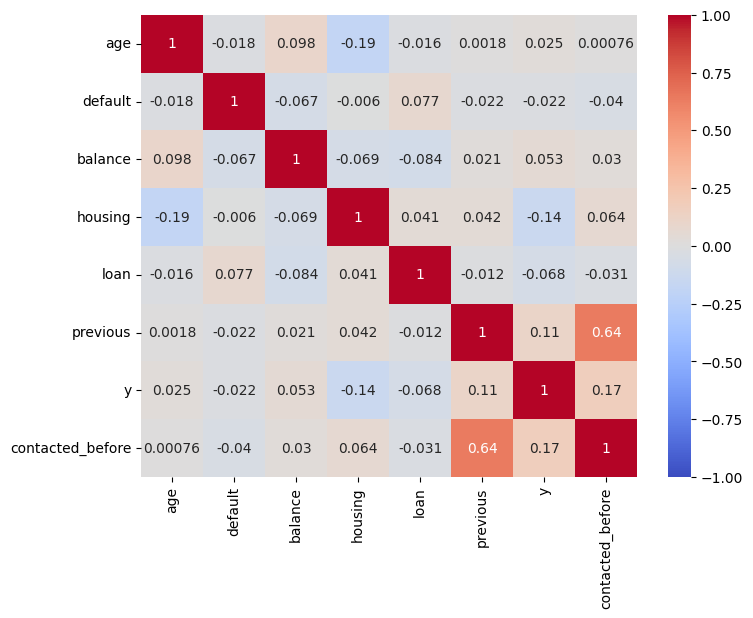

In [100]:
cm = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [ ]:
# as expected, there a correlation between "previous" and "contacted_before".

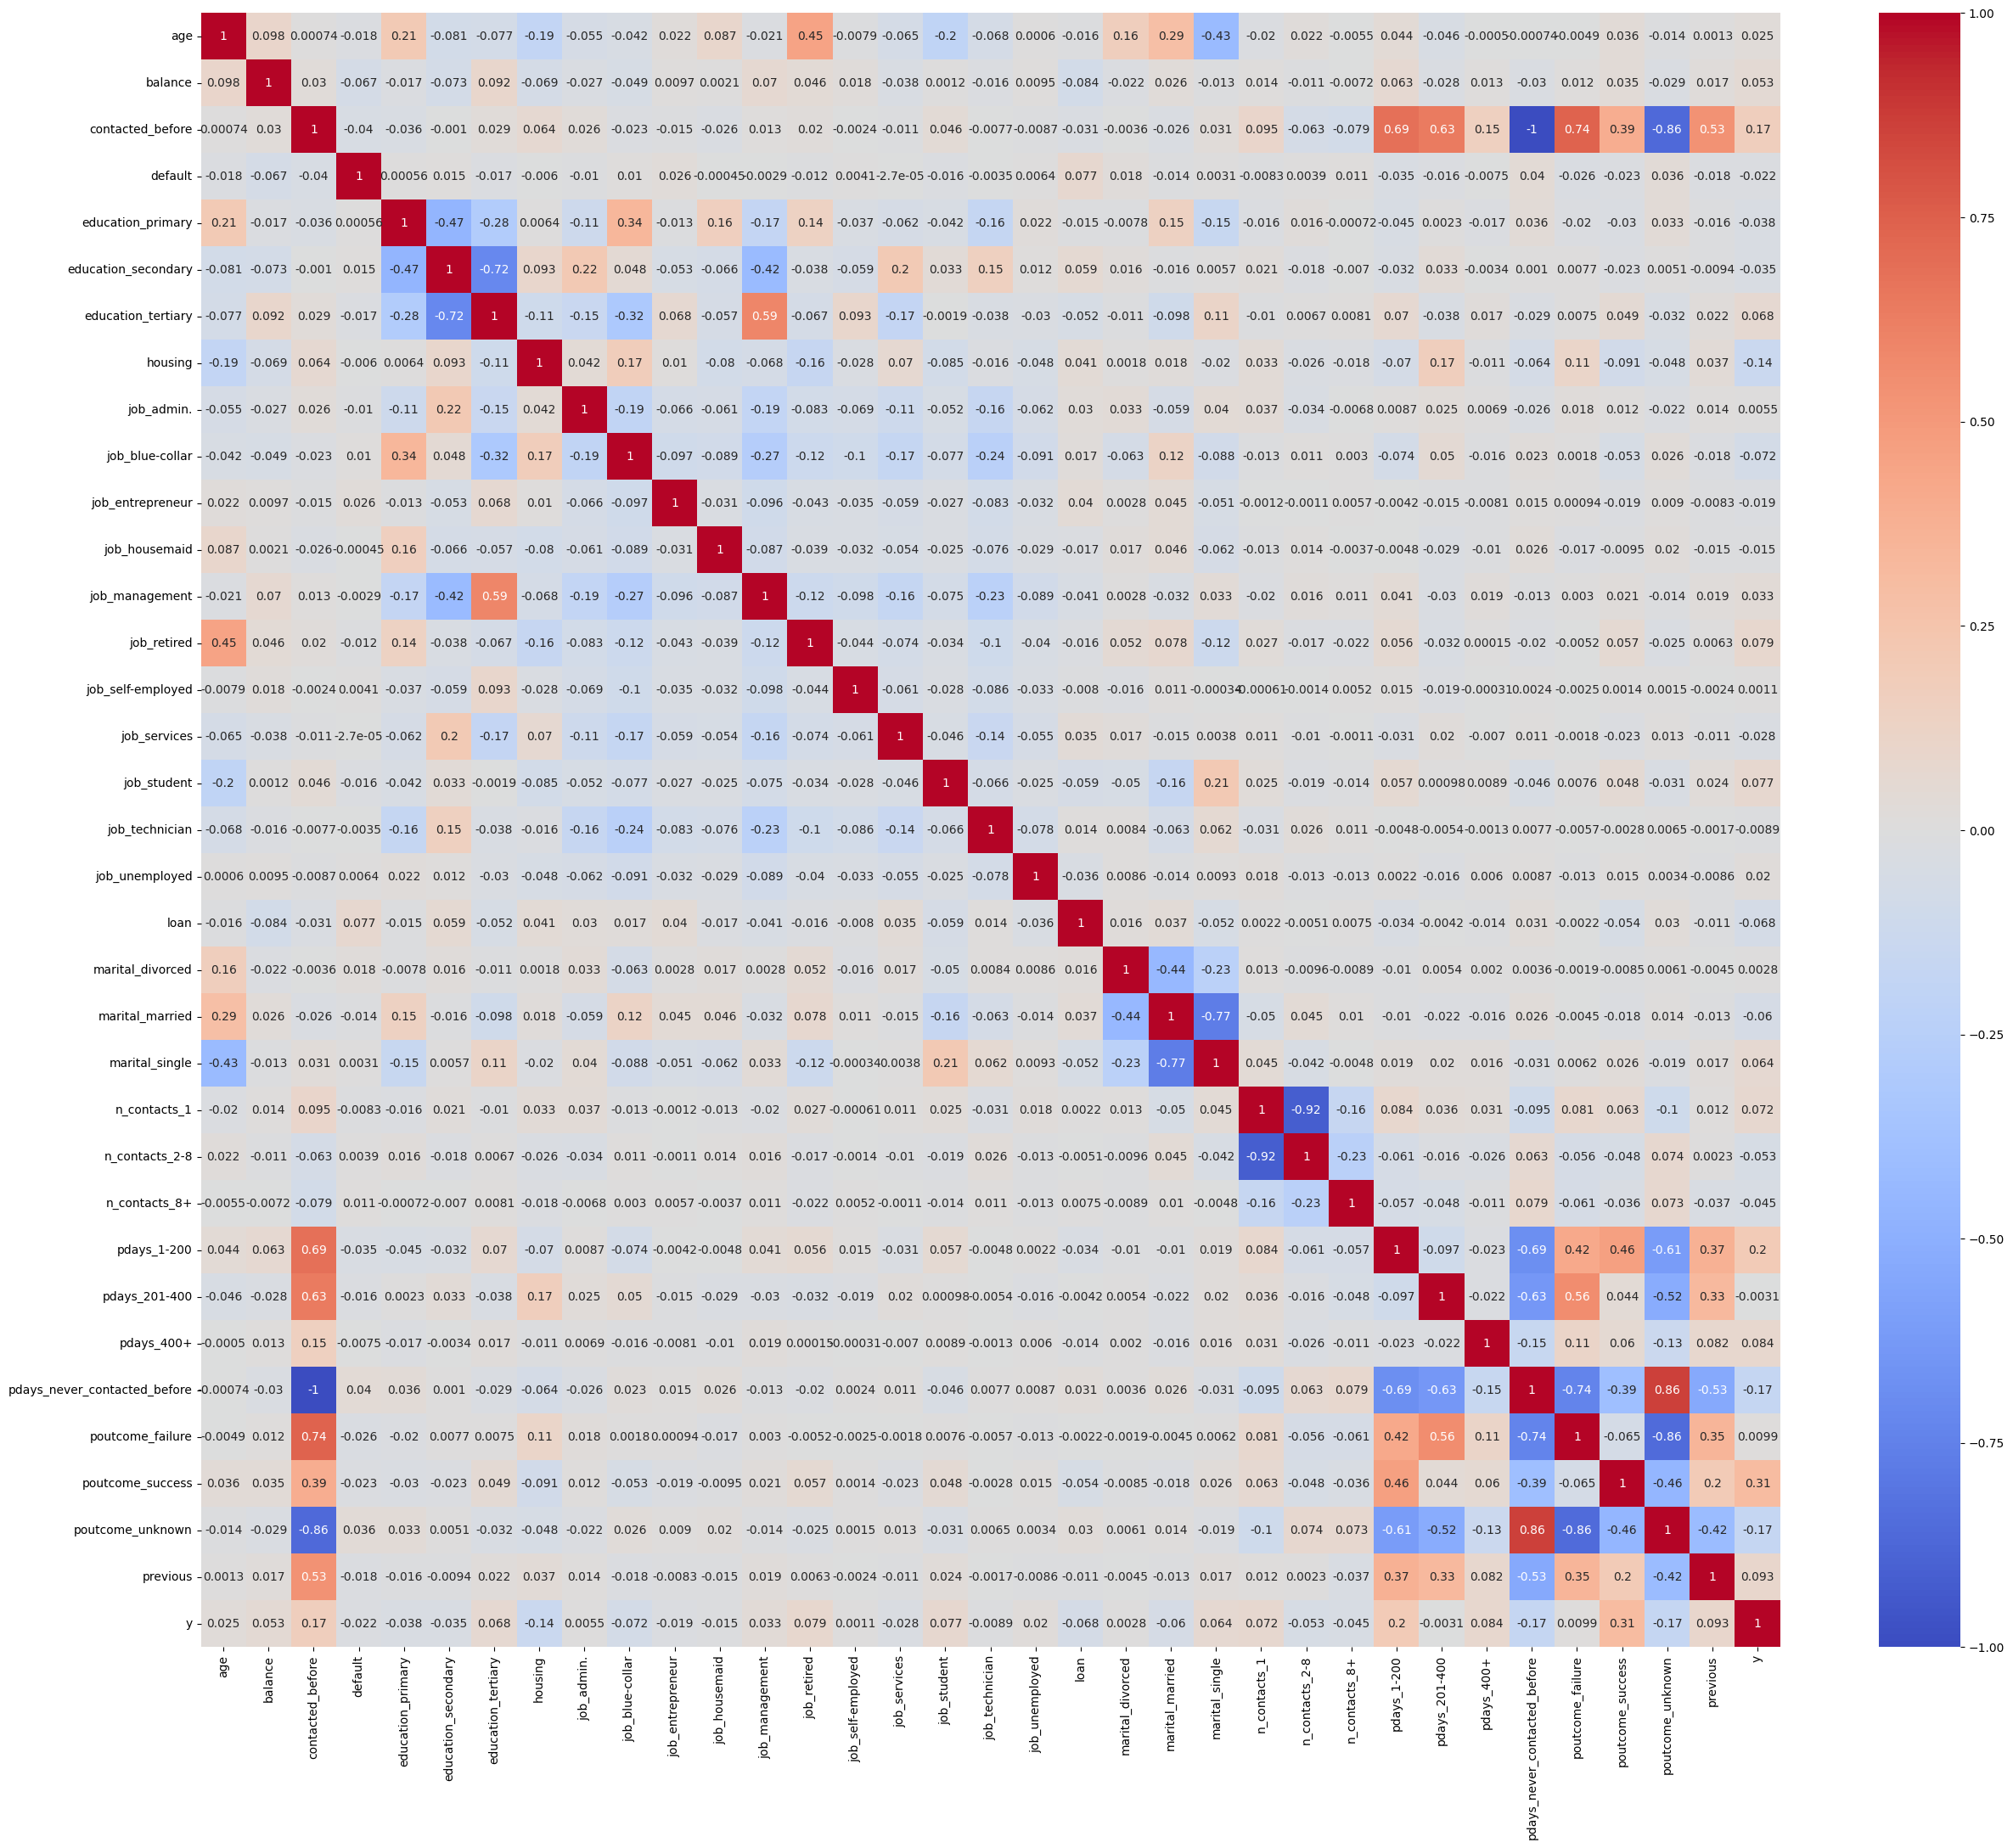

In [98]:
cm = ohe_df.corr()

plt.figure(figsize=(30, 25))
sns.heatmap(cm, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [ ]:
# most of the correlation highlighted above reflect what already emerged during the data exploration,
# or the intrinsic similarity between feature with similar meaning, or the link of "contacted_before"
# with the other related feature.
# Given this, "contacted_before" can be considered to contain redundant information and may be removed.
# However, the models I'll use are robust to correlation between feature, and following what done in [3],
# I'll keep correlated features for now.

# <ins> EXPORT

In [105]:
ohe_df.to_csv('data/ohe_df.csv', index=False)